In [84]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from networks import fcn_isotropic
import scipy
import torch.nn as nn

In [85]:
data = np.load(r'F:\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\Synthetic_data_no_defect\\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz'

In [3]:
data['meta']

array([['time', '28/10/2025 11:07:19'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '30'],
       ['T2_units', 'frames'],
       ['T3', '300'],
       ['T3_units', 'frames'],
       ['fps', '30.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '334'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '2.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J/(kg

In [4]:
data['data'].shape

(334, 512, 512)

In [5]:
print(f"There is: {512*512} of initial conditions, and there is {(4*512)*3000} boundary conditions") 

There is: 262144 of initial conditions, and there is 6144000 boundary conditions


In [6]:
T,H,W=data['data'].shape
H_center=H//2
W_center=W//2

Text(0.5, 1.0, 'Cooling phase')

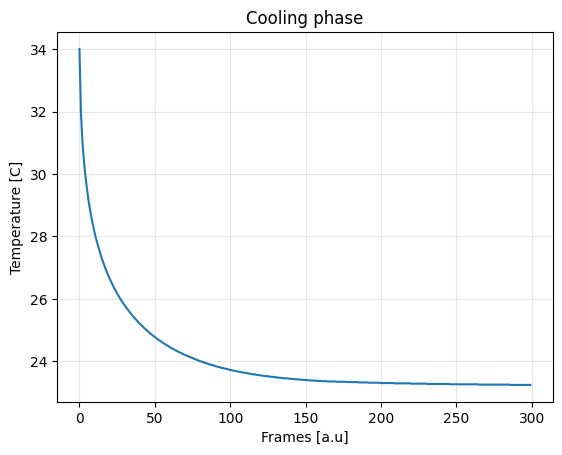

In [7]:
plt.plot(data['data'][34:,H_center,W_center])
plt.ylabel('Temperature [C]')
plt.xlabel('Frames [a.u]')
plt.grid(alpha=0.3)
plt.title('Cooling phase')

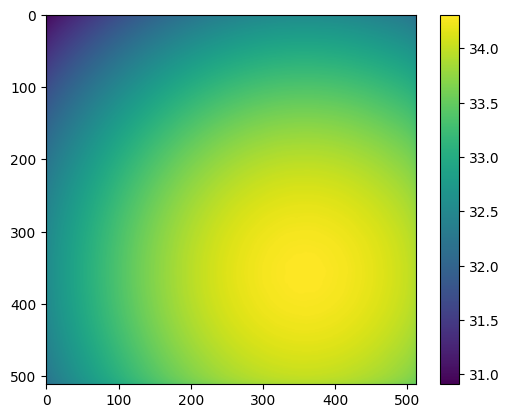

In [8]:
plt.imshow(data['data'][34,:,:])
plt.colorbar()

In [9]:
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Simple network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
    def forward(self, x):
        return self.layers(x)

# Dummy data
x = torch.linspace(-1, 1, 100).unsqueeze(1)
y_true = x.pow(3)

# Model, loss, optimizer
model = Net()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, history_size=10, tolerance_grad=1e-9)

# L-BFGS requires a closure function that reevaluates the loss
def closure():
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y_true)
    loss.backward()
    return loss

# Training
optimizer.step(closure)

# Test result
with torch.no_grad():
    y_pred = model(x)
    print("Final loss:", criterion(y_pred, y_true).item())


Final loss: 3.145639482227125e-07


[Epoch 0] Losses: [0.24007874727249146, 0.0019207451259717345, 0.0004639328981284052], Weights: [0.11072441935539246, 0.11133089661598206, 0.11127804219722748]
[Epoch 50] Losses: [0.20151883363723755, 0.00032117514638230205, 0.002391268266364932], Weights: [0.004981742240488529, 0.07974913716316223, 0.24860243499279022]
[Epoch 100] Losses: [0.217763289809227, 2.7828265956486575e-05, 0.0006059685838408768], Weights: [0.011819718405604362, 0.06488647311925888, 0.2566271424293518]
[Epoch 150] Losses: [0.21653467416763306, 1.0682551874197088e-05, 0.0005444007110781968], Weights: [0.0132546816021204, 0.05976279079914093, 0.26031583547592163]
[Epoch 200] Losses: [0.21468733251094818, 1.969731238204986e-05, 0.0005011316970922053], Weights: [0.015828756615519524, 0.057254016399383545, 0.2602505683898926]
[Epoch 250] Losses: [0.211431086063385, 3.111549813183956e-05, 0.0005084577132947743], Weights: [0.01363387145102024, 0.054803602397441864, 0.26489585638046265]
[Epoch 300] Losses: [0.20800763

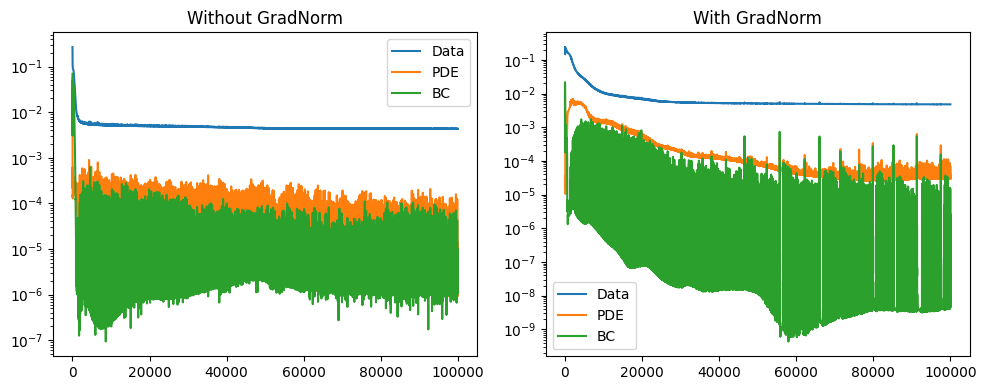

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Simple feedforward network: 2 inputs (x,t), 1 output (u)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# Generate synthetic data
torch.manual_seed(0)
x = torch.rand(100, 1)
t = torch.rand(100, 1)
xt = torch.cat([x, t], dim=1)

u_true = torch.sin(torch.pi * x) * torch.cos(torch.pi * t)
u_noisy = u_true + 0.05 * torch.randn_like(u_true)

# --- Utility function to compute losses ---
def compute_losses(model, xt, u_true):
    xt.requires_grad_(True)
    u_pred = model(xt)

    # 1️⃣ Data loss
    loss_data = torch.mean((u_pred - u_true) ** 2)

    # Compute gradient wrt both x and t
    grads = torch.autograd.grad(u_pred, xt, torch.ones_like(u_pred), create_graph=True)[0]
    u_x = grads[:, 0:1]
    u_t = grads[:, 1:1+1]

    # Second derivative wrt t
    grads_t = torch.autograd.grad(u_t, xt, torch.ones_like(u_t), create_graph=True)[0]
    u_tt = grads_t[:, 1:1+1]

    # 2️⃣ PDE loss: u_tt + u = 0
    loss_pde = torch.mean((u_tt + u_pred) ** 2)

    # 3️⃣ Boundary loss: u(x=0,t)=0
    t = xt[:, 1:2]
    xt_bc = torch.cat([torch.zeros_like(t), t], dim=1)
    u_bc = model(xt_bc)
    loss_bc = torch.mean(u_bc ** 2)

    return loss_data, loss_pde, loss_bc

# ======================================================
# 1️⃣ WITHOUT GRADNORM
# ======================================================
net1 = Net()
optimizer1 = optim.Adam(net1.parameters(), lr=1e-3)

loss_hist_no_gn = []

for epoch in range(100000):
    optimizer1.zero_grad()
    loss_data, loss_pde, loss_bc = compute_losses(net1, xt, u_noisy)
    total_loss = loss_data + 10 * loss_pde + 1 * loss_bc  # arbitrary weights
    total_loss.backward()
    optimizer1.step()
    loss_hist_no_gn.append([loss_data.item(), loss_pde.item(), loss_bc.item()])

# ======================================================
# 2️⃣ WITH GRADNORM
# ======================================================
net2 = Net()
w = nn.Parameter(torch.ones(3))
optimizer2 = optim.Adam(list(net2.parameters()) + [w], lr=1e-3)
alpha = 1.5

# Initial losses
init_losses = torch.tensor([l.item() for l in compute_losses(net2, xt, u_noisy)])


loss_hist_gn = []

for epoch in range(100000):
    optimizer2.zero_grad()
    losses = torch.stack(compute_losses(net2, xt, u_noisy))
    weighted_loss = torch.sum(w * losses)
    
    # Compute grads w.r.t shared params
    shared_params = list(net2.net[-1].parameters())  # first layer
    grad_norms = torch.stack([
        torch.norm(torch.autograd.grad(w[i]*losses[i], shared_params, retain_graph=True, create_graph=True)[0])
        for i in range(3)
    ])
    
    mean_grad = grad_norms.mean().detach()

    # Determining various training rates
    loss_ratio = (losses.detach() / init_losses) # Inverse training rate
    
    # Determining relative inverse training rate
    mean_loss_ratio = loss_ratio.mean() 
    r_i = loss_ratio / mean_loss_ratio

    # Determining target gradient
    target_grad = mean_grad * (r_i ** alpha)
    
    gradnorm_loss = torch.sum(torch.abs(grad_norms - target_grad))
    grad_w = torch.autograd.grad(gradnorm_loss, w, retain_graph=True)[0]

    # Backward pass for network
    weighted_loss.backward()
    optimizer2.step()

    # Manual update for w (outside autograd)
    with torch.no_grad():
        w -= 1e-2 * grad_w
        w[:] = torch.clamp(w, 1e-3)
        w[:] = w / (w.sum() * 3)
    
    loss_hist_gn.append([l.item() for l in losses])
    
    if epoch % 50 == 0:
        print(f"[Epoch {epoch}] Losses: {losses.tolist()}, Weights: {w.tolist()}")

# ======================================================
# 3️⃣ Visualization
# ======================================================
loss_hist_no_gn = torch.tensor(loss_hist_no_gn)
loss_hist_gn = torch.tensor(loss_hist_gn)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Without GradNorm")
plt.plot(loss_hist_no_gn[:,0], label='Data')
plt.plot(loss_hist_no_gn[:,1], label='PDE')
plt.plot(loss_hist_no_gn[:,2], label='BC')
plt.yscale('log')
plt.legend()

plt.subplot(1,2,2)
plt.title("With GradNorm")
plt.plot(loss_hist_gn[:,0], label='Data')
plt.plot(loss_hist_gn[:,1], label='PDE')
plt.plot(loss_hist_gn[:,2], label='BC')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()
